In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()

In [3]:


# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
vocab_size = len(itos)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 5 # context length: how many characters do we take to predict the next one?
device = "mps" if torch.backends.mps.is_available() else "cpu"

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [5]:
n_embed = 10
n_hidden = 200



g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g).to(device)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g).to(device)
b1 = torch.randn(n_hidden, generator=g).to(device)
W2 = torch.randn((n_hidden, vocab_size), generator=g).to(device)
b2 = torch.randn(vocab_size, generator=g).to(device)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [6]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [7]:
lri, lossi, stepi = [], [], []
lr = 0.1
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters: 
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    if i % 1000 == 0:
        print(i, loss.item())

    for p in parameters:
        p.data -= lr * p.grad

    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())



0 23.436016082763672
1000 3.3388023376464844
2000 2.5548932552337646
3000 3.0885138511657715
4000 2.6750664710998535
5000 2.49545955657959
6000 2.176673412322998
7000 2.652280569076538
8000 2.228506088256836
9000 2.510483503341675
10000 2.55269193649292
11000 2.7742185592651367
12000 2.125256061553955
13000 2.5849990844726562
14000 2.6762123107910156
15000 2.0897247791290283
16000 2.682340383529663
17000 2.8153719902038574
18000 2.6112866401672363
19000 2.862135648727417
20000 2.4347028732299805
21000 2.4771337509155273
22000 2.3563547134399414
23000 2.3391506671905518
24000 2.6211302280426025
25000 2.3013241291046143
26000 2.0344014167785645
27000 2.718644618988037
28000 2.8209476470947266


KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.5508642196655273
val 2.575127363204956


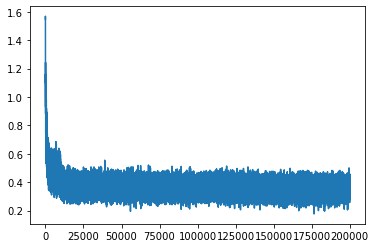

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# sample from the model
g = torch.Generator(device=device).manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).to(device).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))



giirthannai.
dizdan.
nudney.
diwin.
rohiciel.
idine.
chain.
nelick.
railien.
diry.
myneve.
namin.
ivien.
naiquyreda.
mufi.
husen.
khiya.
luiny.
rinmii.
irhise.


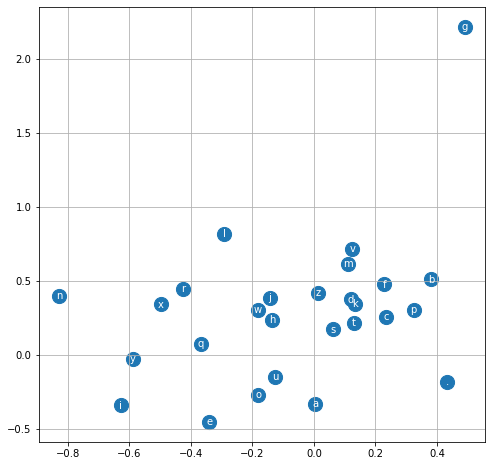

In [ ]:


# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

